# Emotion Detection
#### importing libraries

In [1]:
import matplotlib.pyplot as plt
from glob import glob
import cv2
import random
%matplotlib inline

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from keras.layers import BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import tensorflow as tf

Exploring Dataset

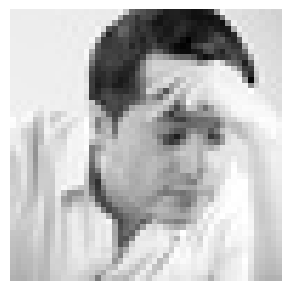

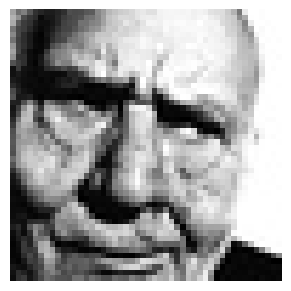

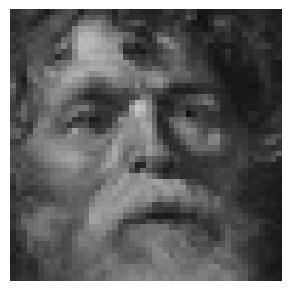

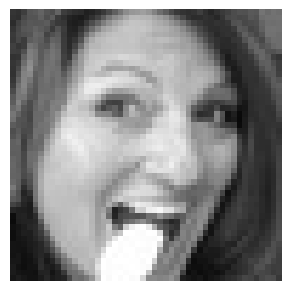

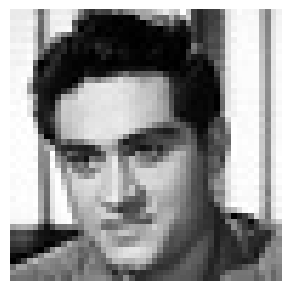

In [2]:
images = glob("train/**/**")
for i in range(5):
    image = random.choice(images)
    plt.figure(figsize=(12,12))
    plt.subplot(331+i)
    plt.imshow(cv2.imread(image))
    plt.axis('off')

##### Preparing data for training

In [3]:
img_size = 48
batch_size = 64
datagen_train = ImageDataGenerator()
train_generator = datagen_train.flow_from_directory("train/",
                                                    target_size= (img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode="categorical",
                                                    shuffle=True)

datagen_validation = ImageDataGenerator()
validation_generator = datagen_train.flow_from_directory("test/",
                                                    target_size= (img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode="categorical",
                                                    shuffle=True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


##### Defining Model

In [4]:
# Convolution Layer
def Convolution(input_tensor, filters, kernel_size):
    x = Conv2D(filters = filters, kernel_size = kernel_size, padding = "same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size = (2,2))(x)
    x = Dropout(0.25)(x)
    
    return x

In [5]:
# Dense Layer
def Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)
    
    return x

In [6]:
def model_fer(input_shape):
    inputs = Input(input_shape)
    conv_1 = Convolution(inputs,32,(3,3))
    conv_2 = Convolution(conv_1,64,(5,5))
    conv_3 = Convolution(conv_2,128,(3,3))

    flatten = Flatten()(conv_3)
    
    dense_1 = Dense_f(flatten,256)

    output  = Dense(7, activation="softmax")(dense_1)
    model  =  Model(inputs=[inputs],outputs = [output])
    
    model.compile(loss=['categorical_crossentropy'] , optimizer = 'adam' , metrics =["accuracy"])

    return model

In [7]:
model = model_fer((48,48,1))
model.summary()




Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 32)        128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0  

##### Initializing the model

In [8]:
epochs = 10
steps_per_epochs = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint("model_weights.h5",monitor='val_accuracy',save_weights_only=True,mode='max',verbose=1)
callbacks = [checkpoint]

# Training the Model

In [9]:
history = model.fit(
    x = train_generator,
    steps_per_epoch=steps_per_epochs,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks
)

Epoch 1/10


448/448 [==============================] - ETA: 0s - loss: 1.6853 - accuracy: 0.3606
Epoch 1: saving model to model_weights.h5
448/448 [==============================] - 282s 623ms/step - loss: 1.6853 - accuracy: 0.3606 - val_loss: 1.5882 - val_accuracy: 0.4009
Epoch 2/10
448/448 [==============================] - ETA: 0s - loss: 1.3902 - accuracy: 0.4660
Epoch 2: saving model to model_weights.h5
448/448 [==============================] - 153s 342ms/step - loss: 1.3902 - accuracy: 0.4660 - val_loss: 1.3419 - val_accuracy: 0.4847
Epoch 3/10
448/448 [==============================] - ETA: 0s - loss: 1.2748 - accuracy: 0.5169
Epoch 3: saving model to model_weights.h5
448/448 [==============================] - 154s 345ms/step - loss: 1.2748 - accuracy: 0.5169 - val_loss: 1.2799 - val_accuracy: 0.5088
Epoch 4/10
448/448 [==============================] - ETA: 0s - loss: 1.2032 - accuracy: 0.5419
Epoch 4: saving model to model_weights.h5
448/448 [==============================] 

##### Model Evaluation

In [10]:
model.evaluate(validation_generator)

113/113 [==============================] - 8s 74ms/step - loss: 1.1073 - accuracy: 0.5911


[1.1073328256607056, 0.5911117196083069]

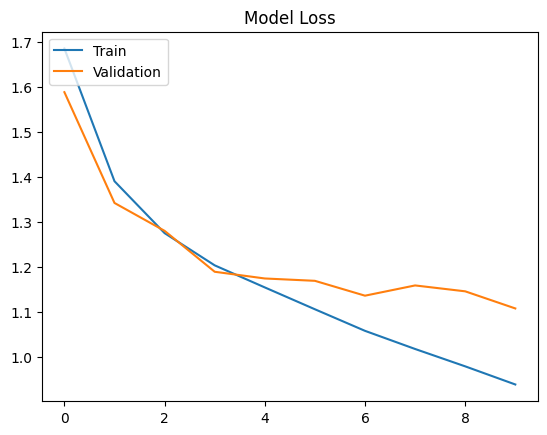

In [11]:
# Plotting Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train','Validation'],loc = 'upper left')

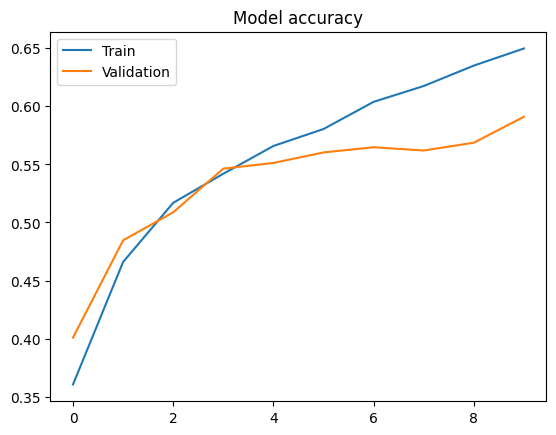

In [12]:
# Plotting accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.legend(['Train','Validation'],loc = 'upper left')

In [14]:
# Saving Model
model_json = model.to_json()
with open("model_a.json","w") as json_file:
    json_file.write(model_json)